In [ ]:
!pip install scikit-learn==1.2.1 xgboost==1.7.5 pandas==2.0.1 numpy==1.22.1 matplotlib==3.7.1

In [ ]:
fpath = '/content/dataset/'
fname = 'Retinopathy_FINAL.csv'
fname1 = 'Retinopathy_FINAL_NIA.csv'

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, balanced_accuracy_score
from scipy import stats
from scipy.stats import sem, t
from imblearn.over_sampling import SMOTE

# 1. confidence_interval
def confidence_interval(metric_scores, confidence=0.95):
    n = len(metric_scores)
    mean = np.mean(metric_scores)
    std_err = stats.sem(metric_scores)
    margin = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean - margin, mean + margin

# 2. Smote dataset
def prepare_data_and_smote(X, y):
    smote = SMOTE(random_state=1)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# 3. Adjust output
def adjusted_output(probas, threshold):
    return (probas >= threshold).astype(int)

In [ ]:
fpath_py = fpath + fname
fpath_py1 = fpath + fname1

In [ ]:
import pandas as pd
whole_data = pd.read_csv(fpath_py)
extra_validation = pd.read_csv(fpath+fname1)

In [ ]:
data_cols = ['met', 'dpp', 'mg', 'thia', 'glu', 'glp', 'sglt', 'angio', 'convert', 'cal', 'di',
    'beta', 'sta', 'fi', 'eze', 'aspi','clo', 'cil','gly','HbA1c_median','Glucose_median','TC_median',
    'TG_median','HDL_median','LDL_median','Cr_median','AST_median','ALT_median','GGT_median','ALP_median',
    'BMI_median','HbA1c_std', 'Glucose_std','TC_std', 'TG_std', 'HDL_std', 'LDL_std', 'Cr_std', 'AST_std',
    'ALT_std','GGT_std', 'ALP_std','BMI_std', 'hypertension', 'dyslipidemia','parkinson', 'demen', 'kidney',
    'endstage', 'neuro', 'malignant', 'CCD', 'PL', 'age','sex']

In [ ]:
label_col = ['RP']

In [ ]:
X1 = whole_data[data_cols]
y1 = whole_data[label_col]

In [ ]:
X1 = X1.select_dtypes(include=[np.number])

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, auc, balanced_accuracy_score

def adjusted_output(predictions, threshold):
    return (predictions >= threshold).astype(int)

def find_optimal_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    optimal_idx = np.argmin(np.abs(tpr - (1 - fpr)))
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Best hyperparameter {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'logloss', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 130, 'random_state': 42, 'scale_pos_weight': 6, 'subsample': 0.7, 'tree_method': 'hist'}
optimal_threshold = 0.10
AUROC: 82.36 (80.48, 84.25)
Sensitivity: 73.88 (69.72, 78.04)
Specificity: 73.76 (72.63, 74.88)
Accuracy: 73.76 (72.68, 74.84)
Balanced Accuracy: 73.82 (71.80, 75.84)


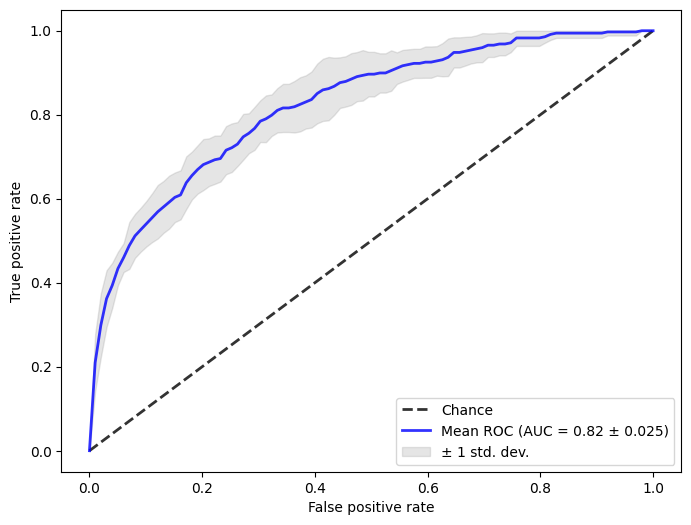

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from scipy.stats import sem, t
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Data preparation and SMOTE
def prepare_data_and_smote(X, y):
    # Apply SMOTE
    smote = SMOTE(random_state=1)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Replace with your actual data loading mechanism
X1 = whole_data[data_cols]
y1 = whole_data[label_col]
X1 = X1.select_dtypes(include=[np.number])

# Define hyperparameters
best_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'logloss',
    'learning_rate': 0.03,
    'max_depth': 5,
    'n_estimators': 130,
    'random_state': 42,
    'scale_pos_weight': 6,
    'subsample': 0.7,
    'tree_method': 'hist'
}

# Initialize model
model = XGBClassifier(**best_params)

# Perform cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sensitivities, specificities, accuracies, aurocs, balanced_accuracies = [], [], [], [], []

# ROC curve variables
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Loop for cross-validation
for train_idx, test_idx in cv.split(X1, y1):
    X_resampled, y_resampled = prepare_data_and_smote(X1, y1)
    cv_train_X, cv_test_X = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
    cv_train_y, cv_test_y = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

    # Training the model
    model = XGBClassifier(**best_params)
    model.fit(cv_train_X, cv_train_y)
    probas_ = model.predict_proba(cv_test_X)[:, 1]

    optimal_threshold = find_optimal_threshold(cv_test_y, probas_) # optimal_threshold = 0.10

    # ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(cv_test_y, probas_)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Interpolate ROC curves
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Performance metrics
    y_pred_adjusted = adjusted_output(probas_, optimal_threshold)
    tn, fp, fn, tp = confusion_matrix(cv_test_y, y_pred_adjusted).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(cv_test_y, y_pred_adjusted)
    balanced_accuracy = (sensitivity + specificity) / 2

    sensitivities.append(sensitivity)
    specificities.append(specificity)
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    aurocs.append(roc_auc)

# Model performance output
mean_sensitivity, se_sensitivity = np.mean(sensitivities), sem(sensitivities)
mean_specificity, se_specificity = np.mean(specificities), sem(specificities)
mean_accuracy, se_accuracy = np.mean(accuracies), sem(accuracies)
mean_balanced_accuracy, se_balanced_accuracy = np.mean(balanced_accuracies), sem(balanced_accuracies)
mean_auroc, se_auroc = np.mean(aurocs), sem(aurocs)

confidence = 0.95
ci_sensitivity = se_sensitivity * t.ppf((1 + confidence) / 2, len(sensitivities) - 1)
ci_specificity = se_specificity * t.ppf((1 + confidence) / 2, len(specificities) - 1)
ci_accuracy = se_accuracy * t.ppf((1 + confidence) / 2, len(accuracies) - 1)
ci_balanced_accuracy = se_balanced_accuracy * t.ppf((1 + confidence) / 2, len(balanced_accuracies) - 1)
ci_auroc = se_auroc * t.ppf((1 + confidence) / 2, len(aurocs) - 1)

print("Best hyperparameter", best_params)
print(f"optimal_threshold = {optimal_threshold:.2f}")
print(f"AUROC: {mean_auroc*100:.2f} ({(mean_auroc-ci_auroc)*100:.2f}, {(mean_auroc+ci_auroc)*100:.2f})")
print(f"Sensitivity: {mean_sensitivity*100:.2f} ({(mean_sensitivity-ci_sensitivity)*100:.2f}, {(mean_sensitivity+ci_sensitivity)*100:.2f})")
print(f"Specificity: {mean_specificity*100:.2f} ({(mean_specificity-ci_specificity)*100:.2f}, {(mean_specificity+ci_specificity)*100:.2f})")
print(f"Accuracy: {mean_accuracy*100:.2f} ({(mean_accuracy-ci_accuracy)*100:.2f}, {(mean_accuracy+ci_accuracy)*100:.2f})")
print(f"Balanced Accuracy: {mean_balanced_accuracy*100:.2f} ({(mean_balanced_accuracy-ci_balanced_accuracy)*100:.2f}, {(mean_balanced_accuracy+ci_balanced_accuracy)*100:.2f})")

# ROC curve plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.3f})', lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='± 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend(loc="lower right")

plt.show()

In [ ]:
extra_X = extra_validation[data_cols]
extra_y = extra_validation[label_col]

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

imputer.fit(whole_data[data_cols])

X = imputer.transform(whole_data[data_cols])

for col in data_cols:
    if col not in extra_X.columns:
        extra_X[col] = np.nan

extra_X = extra_X[data_cols]
extra_X_imputed = imputer.transform(extra_X)
prob_extra_rf = model.predict_proba(extra_X_imputed)[:, 1]
extra_X_imputed = pd.DataFrame(extra_X_imputed, columns=data_cols)

from sklearn.metrics import roc_curve

optimal_threshold = find_optimal_threshold(extra_y, prob_extra_rf)
y_pred_extra_opt = (prob_extra_rf >= optimal_threshold).astype(int)
tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(extra_y, y_pred_extra_opt).ravel()
sensitivity_opt = tp_opt / (tp_opt + fn_opt)
specificity_opt = tn_opt / (tn_opt + fp_opt)
accuracy_opt = accuracy_score(extra_y, y_pred_extra_opt)
balanced_accuracy_opt = balanced_accuracy_score(extra_y, y_pred_extra_opt)
auroc_opt = roc_auc_score(extra_y, prob_extra_rf)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Sensitivity (EXTRA): {sensitivity_opt*100:.2f}")
print(f"Specificity (EXTRA): {specificity_opt*100:.2f}")
print(f"Accuracy (EXTRA): {accuracy_opt*100:.2f}")
print(f"Balanced Accuracy (EXTRA): {balanced_accuracy_opt*100:.2f}")
print(f"AUROC (EXTRA): {auroc_opt*100:.2f}")

Optimal Threshold: 0.07
Sensitivity (EXTRA): 64.96
Specificity (EXTRA): 65.15
Accuracy (EXTRA): 65.14
Balanced Accuracy (EXTRA): 65.06
AUROC (EXTRA): 71.67


Top 15 XGBoost feature importances:
         Feature  Importance
44  dyslipidemia    0.058811
50     malignant    0.047504
43  hypertension    0.030933
47        kidney    0.029880
31     HbA1c_std    0.028978
32   Glucose_std    0.028569
17           cil    0.028090
36       LDL_std    0.027807
35       HDL_std    0.026008
49         neuro    0.025278
51           CCD    0.025227
53           age    0.024910
12           sta    0.023079
19  HbA1c_median    0.022428
34        TG_std    0.021698


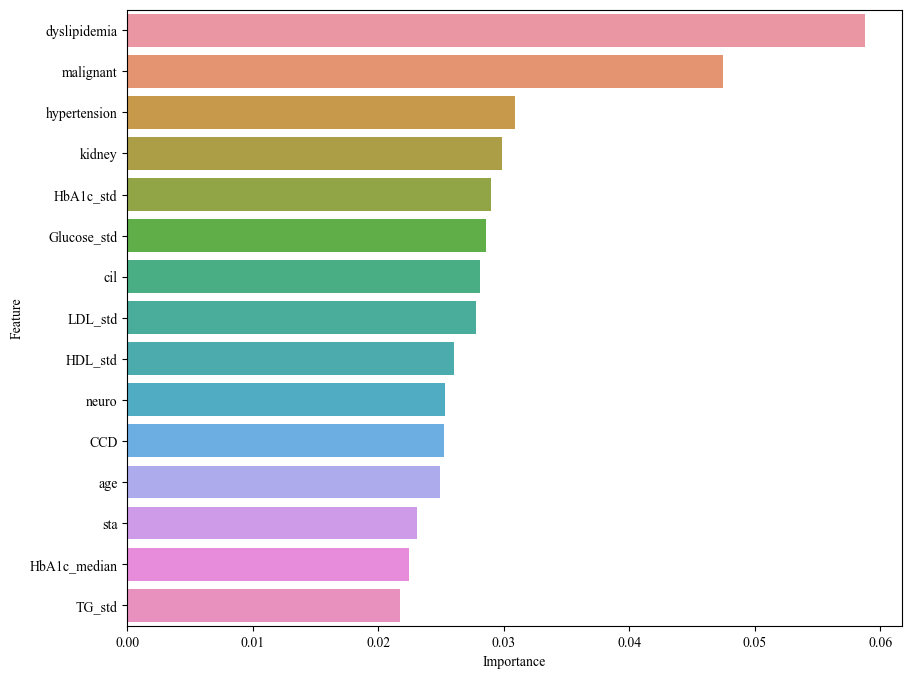

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract feature importances
xgb_feature_importances = model.feature_importances_
xgb_feature_importances_df = pd.DataFrame({"Feature": data_cols, "Importance": xgb_feature_importances})
sorted_xgb_feature_importances = xgb_feature_importances_df.sort_values("Importance", ascending=False)

# Select top 15 features
top_15_features = sorted_xgb_feature_importances.head(15)
print("Top 15 XGBoost feature importances:")
print(top_15_features)

# Visualize top 15 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=top_15_features, x="Importance", y="Feature")
plt.show()